# Jess Plate Analyzer

This script is for the analysis of Jess Data generated. The sample configuration in mind has a 6-point standard curve that has the concentrations: 1.75, 1.5, 1.25, 1.0, 0.75, and 0.5 ug/mL samples; 2 replicates of a "Harvest Control" sample, and 2 replicates for a maximum of eight distinct samples.

In [138]:
## IMPORT STATEMENTS ##

#import pandas library to import the Jess data into the script as a dataframe
import pandas as pd

#import numpy to use polynomial fit function, poly1d
import numpy as np

#import matplotlib for plotting capabilities
import matplotlib.pyplot as plt

#import seaborn for scatterplot (this was what was used in the example and pyplot can be used instead)
import seaborn as sns

#import scikit-learn metrics for the R^2 metric function
from sklearn.metrics import r2_score

#import scipy.stats for
#import scipy.stats as stats

#import math
import math
import cmath


In [139]:

## Script Preparation Section ##
#define the number of samples
num_samp = 8

#this is a vector containing the volume of the sample used. This will be used in the back-calculation of the concentrations of the original samples
samp_vols = [54.3, 54.3, 54.3, 54.3, 54.3, 54.3, 54.3, 54.3]

#standard curve concentrations in ug/mL
std_curve_concs = (1.75, 1.5, 1.25, 1.0, 0.75, 0.5)

## CSV Import Line ##
df_raw = pd.read_csv('data_example/jesstestdata.csv')
df_raw


### Building the dataframe that holds the volumes used in the dilution
substrings_to_exclude = ["Biot. Ladder", "Standard", "STD"]
filtered_samples = [s for s in df_raw['Sample'].unique() if not any(sub in s for sub in substrings_to_exclude)]
filtered_samples

df_samp_vols = pd.DataFrame.from_dict({'Sample':filtered_samples,'Volume':[24]+samp_vols})

## Script Preparation Verification ##
#num_samp needs to be the same as the length of the samp_vols vector. If this is not the case, then

if num_samp not in range(1,9):
    raise ValueError('num_samp must be between 1 and 8')
    exit()

if num_samp + 1 != len(df_samp_vols):
    raise ValueError('num_samp must equal len(samp_vols)')
    exit()

In [140]:
### PREPARE THE DATAFRAMES ###

## Sample Dataframe
#this line uses regex (ew) to recognize the rows that contain data for the samples and not
df_samples = df_raw[~df_raw['Sample'].str.contains(r'Biot\. Ladder|Standard|STD', case = False, regex=True)][["Sample","Area"]]

#uncomment below to verify df_samples was created correctly
#df_samples

## Standard Dataframe
df_standards = df_raw[df_raw['Sample'].str.contains(r'Standard|STD', case = False, regex=True)][["Sample", "Area"]]
df_standards.insert(loc = 1, column = "Concentration", value = std_curve_concs)

#uncomment below to verify df_standards was created correctly
#df_standards

In [141]:
### PLOTTING THE STANDARD CURVE SAMPLES NO MODELING ###
#sns.scatterplot(data = df_standards, x = 'Concentration', y = 'Area')
#plt.title("Standard Curve for Jess Plate")
#plt.xlabel("Concentration (ug/mL)")
#plt.ylabel("Area")

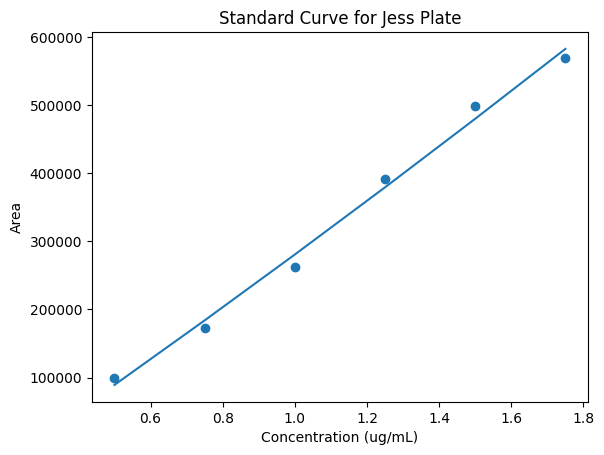

The quadratic equation for this standard curve is: 
            2
1.567e+04 x + 3.59e+05 x - 9.409e+04 

The R^2 value for the curve is:  0.9925342094429171


In [142]:
### APPLYING QUADRATIC FIT AND PLOTTING STANDARD CURVE ###
model = np.poly1d(np.polyfit(df_standards['Concentration'], df_standards['Area'], 2))

polyline = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75]
plt.scatter(df_standards['Concentration'], df_standards['Area'])
plt.plot(polyline, model(polyline))
plt.title("Standard Curve for Jess Plate")
plt.xlabel("Concentration (ug/mL)")
plt.ylabel("Area")
plt.show()


print("The quadratic equation for this standard curve is: \n", model, "\n")
print("The R^2 value for the curve is: ", r2_score(df_standards['Area'], model(df_standards['Concentration'])))


In [143]:
### Back-Calculation for Sample Concentrations ###

#here, we unpack the coefficients of the model and create a column in df_samples to hold the back-calculated concentrations
a, b, c = model

#application of first portion of quadratic formula under the root sign
discriminant = (b**2) - (4 * a * (c-df_samples['Area']))

#application of the rest of the quadratic formula
df_samples["Load Concentration"] = np.where(discriminant >= 0, (-b + np.sqrt(discriminant))/(2*a), np.nan)

#accounts for the 1:10 dilution
df_samples['Int. Conc.'] = df_samples['Load Concentration'] * 10
df_samples

#merge with the sample volumes used in the dilution down to 10ug/mL for back-calculation of the original concentration
df_samples_merged = df_samples.merge(df_samp_vols, left_on = 'Sample', right_on = "Sample",how = "left" )

#back-calculation of the original concentration
df_samples_merged['Original Concentration'] = (300*df_samples_merged["Int. Conc."])/df_samples_merged["Volume"]
df_samples_merged

,Sample,Area,Load Concentration,Int. Conc.,Volume,Original Concentration
0,Harvest Control,640555.4,1.890234,18.902341,24.0,236.279264
1,Harvest Control,671095.9,1.963050,19.630500,24.0,245.381255
2,Sample 1,281330.2,1.001846,10.018460,54.3,55.350609
3,Sample 1,287395.0,1.017370,10.173699,54.3,56.208280
4,Sample 2,246692.7,0.912812,9.128122,54.3,50.431613
5,Sample 2,264187.7,0.957862,9.578620,54.3,52.920551
6,Sample 3,309008.1,1.072536,10.725357,54.3,59.256116
7,Sample 3,296069.4,1.039540,10.395399,54.3,57.433143
8,Sample 4,289137.1,1.021825,10.218255,54.3,56.454447
9,Sample 4,297527.9,1.043264,10.432637,54.3,57.638877


In [146]:
###FINAL SUMMARY DATAFRAME By Sample ###
final_data = df_samples_merged.groupby("Sample")["Original Concentration"].agg(['mean', 'std'])
final_data['cv'] = final_data['std']/final_data['mean']
final_data

final_data = final_data.iloc[1:]


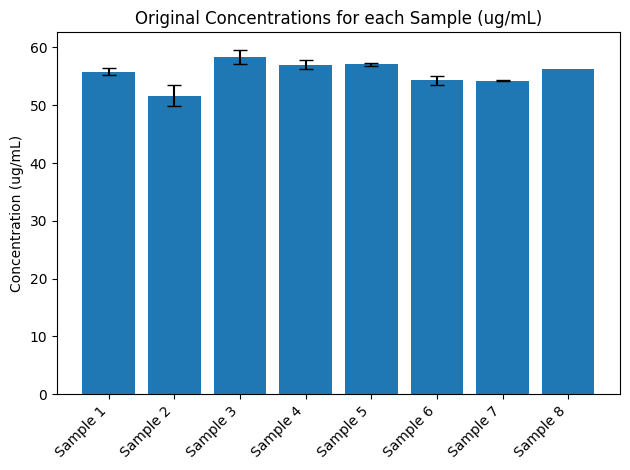

In [147]:
### PLOTTING OF THE FINAL DATAFRAME ###
# this line 
plt.bar(final_data.index, final_data['mean'], yerr = final_data['std'], capsize = 5)
plt.title("Original Concentrations for each Sample (ug/mL)")
plt.ylabel("Concentration (ug/mL)")
plt.xticks(rotation = 45, ha = "right")
plt.tight_layout()